### Face Detection using PCA

Using PCA mechanism to correctly assign the face images to persons on the [Yale Face Dataset](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/). Download the training data and testing data in this link.

#### Assignment 1 (4 scores): Implement PCA using Numpy.

#### Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

#### Assignment 3 (2 scores):
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

**Họ và tên SV**: Trần Phi Quyên

**MSSV**: 23521330

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.transform import resize
import random

In [34]:
random.seed(42)

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
BASE_DIR = '/content/drive/MyDrive/DS102 - LAB/LAB-2025/LAB4/yalefaces/yalefaces/'
person_folders = [f'person-{i}' for i in range(1,16)]

In [37]:
person_folders

['person-1',
 'person-2',
 'person-3',
 'person-4',
 'person-5',
 'person-6',
 'person-7',
 'person-8',
 'person-9',
 'person-10',
 'person-11',
 'person-12',
 'person-13',
 'person-14',
 'person-15']

In [38]:
[f for f in person_folders if f not in os.listdir(BASE_DIR)]

[]

In [39]:
BASE_DIR

'/content/drive/MyDrive/DS102 - LAB/LAB-2025/LAB4/yalefaces/yalefaces/'

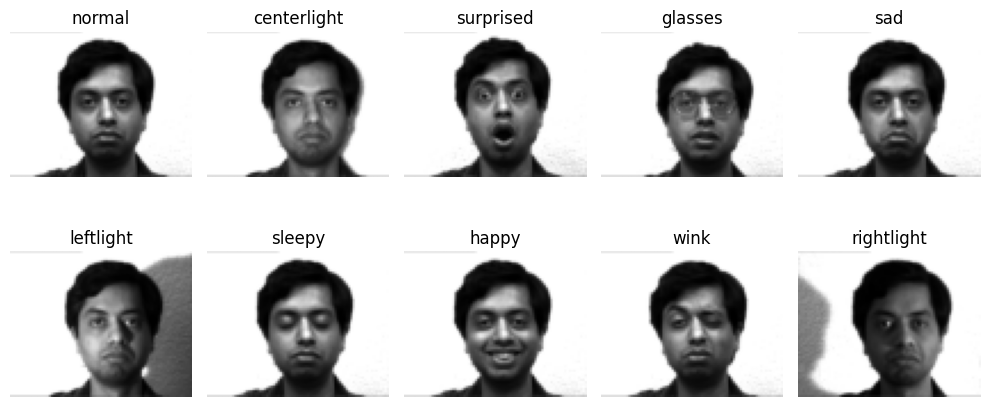

In [40]:
person_folder = random.choices(person_folders)
plt.figure(figsize=(10,5))

for ith, filename in enumerate([filename for filename in os.listdir(BASE_DIR + person_folder[0] + '/')]):

  image = imread(os.path.join(BASE_DIR, person_folder[0], filename))
  image = image.squeeze(0)
  image = resize(image, (64, 80), anti_aliasing=True)

  plt.subplot(2, 5, ith+1)
  plt.imshow(image, cmap='gray')
  plt.title(filename)
  plt.axis('off')

plt.tight_layout()
plt.show()


In [41]:
data = {}

for person_folder in person_folders:
  for filename in os.listdir(os.path.join(BASE_DIR, person_folder)):
    image = imread(os.path.join(BASE_DIR, person_folder,filename))
    image = resize(image, (1,64, 80), anti_aliasing=True)
    if person_folder not in data:
      data[person_folder] = [image]
    else:
      data[person_folder].append(image)
for person in data:
  data[person] = np.concatenate(data[person], axis=0).reshape(10, -1)

In [42]:
data

{'person-1': array([[0.91437407, 0.91476007, 0.91463773, ..., 0.65048214, 0.65848231,
         0.67847082],
        [0.91481718, 0.91481718, 0.91481718, ..., 0.87114935, 0.87036782,
         0.87194764],
        [0.30900828, 0.30331814, 0.29659156, ..., 0.69253353, 0.67212907,
         0.61577715],
        ...,
        [0.91481718, 0.91481718, 0.91481718, ..., 0.87126887, 0.87074279,
         0.87131064],
        [0.91481718, 0.91481718, 0.91481718, ..., 0.87058818, 0.86957833,
         0.87048802],
        [0.91481718, 0.91481718, 0.91481718, ..., 0.86804194, 0.86395773,
         0.86463203]]),
 'person-2': array([[0.89595612, 0.91313089, 0.90588803, ..., 0.6259082 , 0.69426947,
         0.64573501],
        [0.89631109, 0.91342043, 0.90597603, ..., 0.62035341, 0.68818643,
         0.63807171],
        [0.89447974, 0.91290689, 0.90549205, ..., 0.59932363, 0.6658817 ,
         0.61883413],
        ...,
        [0.89855503, 0.91362021, 0.90665801, ..., 0.61239223, 0.68460755,
         0

### Chuẩn hóa ảnh

In [43]:
def standardizing(images: np.ndarray) -> np.ndarray:
  images = (images - images.mean()) / images.std()
  images = images.astype(np.float32)
  return images

### Principle Components Analysis

In [44]:
class PrincipleComponentAnalysis:

  def __init__(self, d_principle: int = 1):
    self.d_principle = d_principle # số chiều giữ lại sau PCA

  def fit(self, X: np.ndarray):
    cov = X.T @ X # X (m, n) => X.T @ X => (n, m) @ (m, n)
    # => (n, n) đo mức độ tương quan giữa các features

    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # đổi dấu
    max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
    signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
    eigenvectors *= signs[np.newaxis,:]
    eigenvectors = eigenvectors.T # số vector, số chiều

    # tạo danh sách [(trị riêng, vector riêng)]
    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i,:]) for i in range(eigenvectors.shape[0])]

    # sắp xếp theo trị riêng giảm dần
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)

    # tách vector riêng, trị riêng
    eigenvalues = np.array([value for (value, _) in eigen_pairs])
    eigenvectors = np.array([value for (_, value) in eigen_pairs])

    self.principle_values = eigenvalues[:self.d_principle]
    self.principle_vectors = eigenvectors[:self.d_principle]

  def transform(self, X: np.ndarray) -> np.ndarray:
    return self.principle_vectors @ X

### Finding the priciple components

In [45]:
PCA = PrincipleComponentAnalysis(d_principle=20)
images = []
for person in data:
  images.append(data[person])

images = np.concatenate(images, axis=0)
images = standardizing(images)
mean_img = images.mean(axis=0)
centered_images = images - mean_img
PCA.fit(images)

In [46]:
PCA.principle_vectors.shape

(20, 5120)

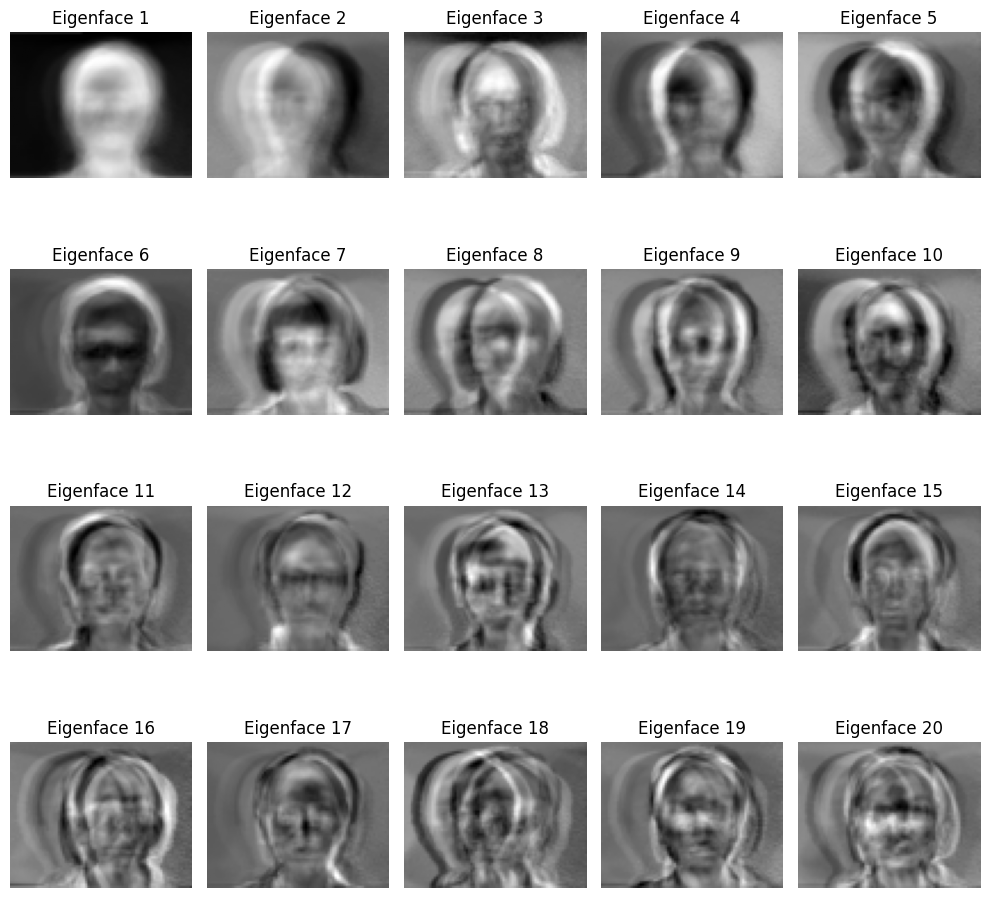

In [47]:
eigenfaces = PCA.principle_vectors.reshape(20, 64, 80)

plt.figure(figsize=(10,10))
for ith, eigenface in enumerate(eigenfaces):
  plt.subplot(4, 5, ith+1)
  plt.imshow(np.real(eigenface), cmap='gray')
  plt.axis('off')
  plt.title(f'Eigenface {ith+1}')
plt.tight_layout()
plt.show()

### Finding meanfaces

In [48]:
mean_faces = {
    person: np.mean(images, axis=0) for person, images in data.items()
}

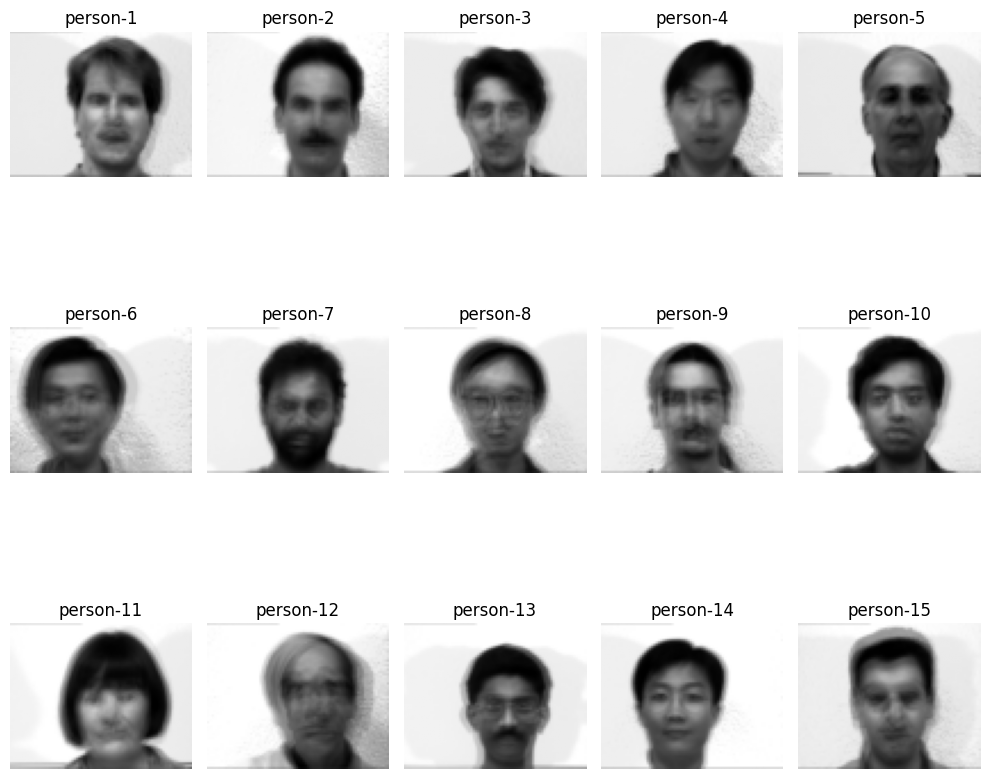

In [49]:
plt.figure(figsize=(10,10))
for ith, person in enumerate(mean_faces):
  mean_face = mean_faces[person]
  mean_face = mean_face.reshape(64, 80)
  plt.subplot(3, 5, ith+1)
  plt.imshow(mean_face, cmap='gray')
  plt.axis('off')
  plt.title(person)
plt.tight_layout()
plt.show()

In [50]:
projected_mean_faces = {}

for person in mean_faces:
  projected_mean_faces[person] = PCA.transform(mean_faces[person])

### Loading test data

In [51]:
labels = []

test_images = []
TEST_DIR = BASE_DIR + 'test/'

In [52]:
for filename in os.listdir(TEST_DIR):
  person_name = filename.split('.')[0]
  labels.append(person_name)

  image = imread(os.path.join(TEST_DIR, filename))
  image = resize(image, (1, 64, 80), anti_aliasing=True)
  test_images.append(image)

In [53]:
test_images = np.concatenate(test_images, axis=0)
# test_images = standardizing(test_images)
test_images.shape

(15, 64, 80)

In [54]:
labels

['person-1',
 'person-7',
 'person-10',
 'person-5',
 'person-9',
 'person-12',
 'person-14',
 'person-6',
 'person-3',
 'person-11',
 'person-2',
 'person-15',
 'person-4',
 'person-13',
 'person-8']

In [55]:
def Euclide_distance(X: np.ndarray, Y: np.ndarray):
  assert X.shape == Y.shape, f'{X.__str__()} and {Y.__str__()} are miss-shaped'
  return (((X - Y)**2).sum())**0.5

In [56]:
predictions = {}

for label, image in zip(labels, test_images):
  image = image.reshape(-1)
  projected_face = PCA.transform(image)
  closest_distance = np.inf
  closest_person = None
  for person in projected_mean_faces:
    mean_face = projected_mean_faces[person]
    distance = Euclide_distance(mean_face, projected_face)
    if distance < closest_distance:
      closest_distance = distance
      closest_person = person
  predictions[label] = closest_person

In [57]:
EMs = []

for label in predictions:
  EMs.append(label == predictions[label])

In [59]:
print(f'Accuracy: {(np.mean(EMs)*100): 0.2F}%')

Accuracy:  66.67%
